# <span style="font-family:Times New Roman">Code 4. Предсказание жанра</span> 

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import os
import time
import pickle
import glob
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cosine

from get_features import get_song_features_set_1, get_song_name

Импортируем стиль визуализации из файла `custom_mplstyle.txt`

In [2]:
plt.style.use('ExtraData\\custom_mplstyle.txt')

Импортируем необходимые списки

In [3]:
with open('ExtraData\\genre_names.txt', 'r') as f:
    genre_names = f.read().split(';')

In [4]:
with open('ExtraData\\genre_names_rus.txt', 'r') as f:
    genre_names_rus = f.read().split(';')

In [5]:
with open('ExtraData\\genre_codes.pkl', 'rb') as f:
    genre_codes = pickle.load(f)

Функция `GenreClassifierType1` для создания выбранной модели нейронной сети (CNN)

In [6]:
def GenreClassifierType1(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=1),

        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=1),        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv1D(filters=256, kernel_size=16, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=1),        
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax', 
                              kernel_regularizer=tf.keras.regularizers.L1(l=0.15)
                             )
    ])

    return model

Функция `GenreClassifierType2` для создания выбранной модели нейронной сети (Perceptron)

In [7]:
def GenreClassifierType2(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return model

Основная функция `GenrePrediction` для определния вероятности принадлежности аудиофайла к каждому из жанров
* Получаем название аудиофайла, его размер в памяти.
* Получаем набор характеристик с помощью функции `get_song_features_set_1`.
* С помощью `sklearn.preprocessing.StandardScaler` преобразуем характеристики для загрузки в модель.
* Загружаем сохранённые веса модели и с помощью `model.predict` получаем вектор вероятностей $(1 х 10)$
* Создаём DataFrame для набора вероятностей для каждого жанра

In [22]:
def GenrePrediction(path, model_type='first', save=True):
    song_name = re.compile('Music\\\\(.*)\..*').findall(path)[0].strip() 
    song_size = np.round(os.path.getsize(path) / (1024 ** 2), 1)

    stime = time.time()
    song_features_dict = get_song_features_set_1(path)
    song_features = np.array([list(song_features_dict.values())])
    X = pd.read_csv('Sets\\features_set_2_2.csv', index_col=[0]).drop(columns=['genre'])
    song_features = StandardScaler().fit(X).transform(song_features).reshape(1,-1,1)

    if model_type == 'first':
        model = GenreClassifierType1(song_features.shape[1:])
        model.load_weights('ExtraData\\cnn_model_set_2_2.h5')
    elif model_type == 'second':
        model = GenreClassifierType2(song_features.shape[1:])
        model.load_weights('ExtraData\\perceptron_model_set_2_2.h5')
    prediction = model.predict(song_features, verbose = 0, batch_size=8)

    genre_pred_df = pd.DataFrame({'Genres' : genre_names, 'Probability' : np.round(prediction[0], 3)})
    genre_pred_df.sort_values('Probability', ascending=False, inplace=True)
    genre_pred_df = genre_pred_df[genre_pred_df.Probability > 0]
    genre_pred_df.Genres.replace(genre_names, genre_names_rus, inplace=True)
    ftime = np.round(time.time() - stime, 2)

    g = genre_pred_df.Genres.values
    p = genre_pred_df.Probability.values
    
    print(f'''Название файла:\t\t\t{song_name}\nРазмер файла:\t\t\t{song_size} MB\
          \nВремя расчёта параметров:\t{ftime} seconds\n\n\t\tПредполагаемый жанр:''')
    for i in range(genre_pred_df.shape[0]):
        print(f'c вероятностью {p[i] * 100 :.1f}%\t\t{g[i]}')
    
    models = {'first':'CNN', 'second':'MLP'}
    GenrePredictionPlot(genre_pred_df, song_name, song_size, ftime, models[model_type], save)

    return genre_pred_df

Дополнительная функция `GenrePredictionPlot` для построения визуализации работы модели
* Вывод "карточки" аудиофайла, где описаны название, размер, время вычислений и `barplot` вероятностей принадлежности к жанру

In [23]:
def GenrePredictionPlot(df, name, size, time_, model_type, save):
    colors = ['#18c0c4', '#f62196', '#A267F5', '#f3907e', '#ffe46b', '#fefeff', '#667EF5']
    colors_edge = ['#0b5d5e', '#5c0c38', '#3d275c', '#59352e', '#665b2b', '#656566', '#030C3A']
    
    if df.Probability.size > 6:
        df_0 = df.iloc[:6].copy()
        records = {'Genres' : 'Другое', 'Probability' : df.iloc[6:].Probability.sum()}
        df = pd.concat([df_0, pd.DataFrame.from_records([records])], ignore_index=True)
    
    if (df.Probability < 0.01).sum() > 1:
        df_0 = df[df.Probability > 0.01].copy()
        records = {'Genres' : 'Другое', 'Probability' : df[df.Probability < 0.01].Probability.sum()}
        df = pd.concat([df_0, pd.DataFrame.from_records([records])], ignore_index=True)
    
    g = df.Genres.values
    p = df.Probability.values
    
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.ylim(-0.05, 1.9)
    
    fig.patch.set_facecolor('whitesmoke')
    ax.patch.set_facecolor('whitesmoke')

    spine_list = ['top', 'right', 'bottom', 'left']
    for s in spine_list:
        ax.spines[s].set_visible(True)
        ax.spines[s].set_linewidth(1)
        ax.spines[s].set_color('black')
    
    t = plt.text(0.05, 1.7, name, fontsize=58, color='black', ha='left', va='top')
    r = fig.canvas.get_renderer()
    bb = t.get_window_extent(renderer=r)
    
    if bb.width > 800:
        i = 1
        while bb.width > 800:
            t.remove()
            fig.canvas.draw()
            t = plt.text(0.05, 1.6, name, fontsize=58-i, color='black', ha='left', va='top')
            bb = t.get_window_extent(renderer=r)
            i = i + 1
    
    plt.text(0.05, 1.77, 'Название аудиофайла: Music/', fontsize=18, color='black')
    plt.text(0.05, 1.3, f'Размер аудифайла: {size} MB', fontsize=18, color='black')
    plt.text(0.05, 1.2, f'Время расчёта параметров: {time_} seconds', fontsize=18, color='black')
    plt.text(0.05, 1.1, f'Классификатор: {model_type}', fontsize=18, color='black')

    for i in range(len(p)):
        ax.bar(i, height=p[i], width=0.95, align='edge', color=colors[i])
        ax.text(i+0.5, 0.6, g[i], fontsize=19, color='black', ha='center', va='center', weight="bold")
        ax.text(i+0.5, 0.5, str(np.round(p[i]*100, 2))+'%', fontsize=16, color='black', ha='center', va='center')
        ax.hlines(0.55, i+0.35, i+0.65, color='black', lw=.5)
        ax.add_patch(Rectangle((i+0.05, 0.4), 0.85, 0.3, color=colors[i], ec=colors_edge[i], lw=1))
        
    plt.xticks([])
    plt.yticks([])
    if save:
        plt.savefig(f'Images\\GC_{name}_{model_type}.png', facecolor="white", bbox_inches = 'tight', dpi = 300)
    plt.show()

Список аудиофайлов-примеров:

In [53]:
path = 'C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\Music'
files = glob.glob(path + "*\\*.wav")

In [86]:
files[69:74]

['C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\Music\\The Police – Every Breath You Take.wav',
 'C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\Music\\The Weeknd – Blinding Lights.wav',
 'C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\Music\\The Weeknd – Call Out My Name.wav',
 'C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\Music\\The Weeknd – I Feel It Coming.wav',
 'C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\Music\\Uma2rman – Прасковья.wav']

Предсказание жанра аудиофайла:

Название файла:			Uma2rman – Прасковья
Размер файла:			7.2 MB          
Время расчёта параметров:	4.24 seconds

		Предполагаемый жанр:
c вероятностью 88.6%		Поп
c вероятностью 11.3%		Диско
c вероятностью 0.1%		Хип-Хоп


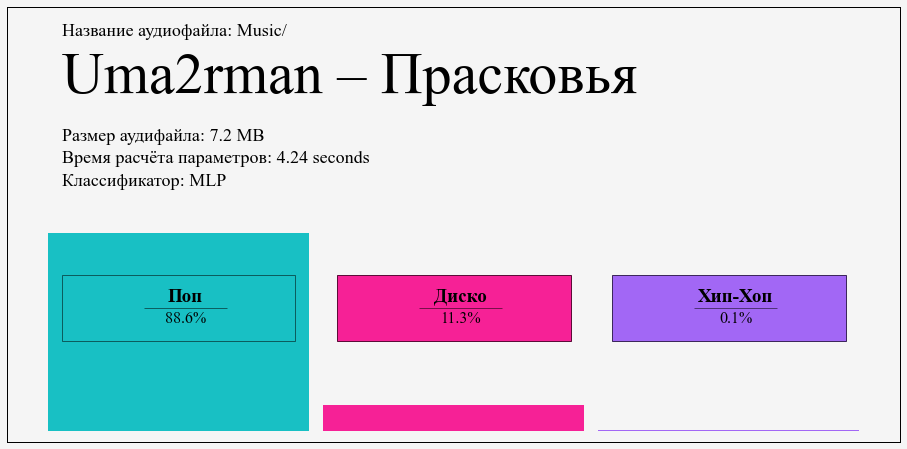

In [87]:
prediction = GenrePrediction(files[73], 'second')

Название файла:			Uma2rman – Прасковья
Размер файла:			7.2 MB          
Время расчёта параметров:	4.43 seconds

		Предполагаемый жанр:
c вероятностью 49.4%		Поп
c вероятностью 47.4%		Диско
c вероятностью 1.4%		Регги
c вероятностью 0.4%		Кантри
c вероятностью 0.3%		Джаз
c вероятностью 0.3%		Рок
c вероятностью 0.2%		Блюз
c вероятностью 0.2%		Хип-Хоп
c вероятностью 0.2%		Метал


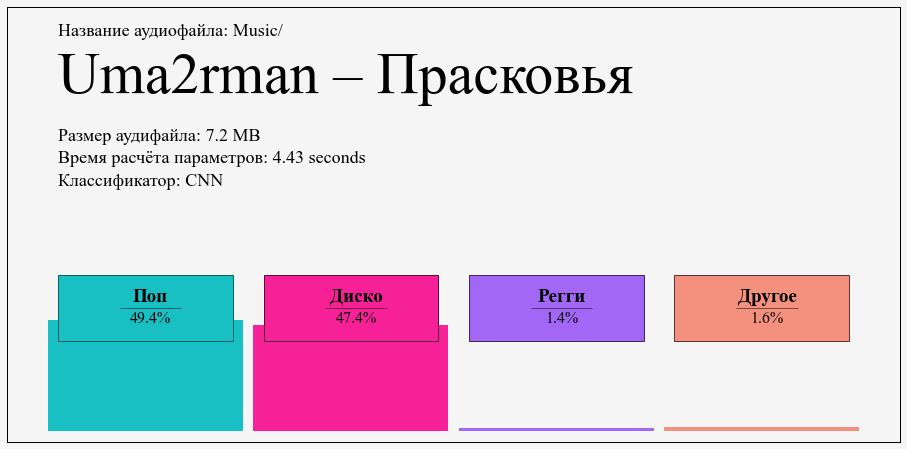

In [88]:
prediction = GenrePrediction(files[73], 'first')